In [ ]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# os
import os
# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# tf
import tensorflow as tf
# keras
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, GRU, LSTM, SimpleRNN, Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.regularizers import l1,l2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import btc
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Make pd df
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NN - 434/btc.csv')

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop extraneous columns
df.drop(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], axis = 1, inplace = True)
# Drop bottom 3m rows and top 800k
df.drop(df.index[:3000000], axis = 0, inplace = True)
df.drop(df.index[4000000:], axis = 0, inplace = True)
# Reset index; drop column
df.reset_index(drop = True, inplace = True)
# Backfill na's
df.fillna(method = 'backfill', inplace = True)

In [ ]:
# RNN target/features
features = ['Weighted_Price']
target = 'Weighted_Price'

In [ ]:
# Split train sets
train_weight = 0.8
df_split = int( len(df) * train_weight )

train = df.iloc[:df_split]
test = df.iloc[df_split:]

In [ ]:
# Scaling parameters
mu = float( train[features].mean() )
sigma = float( train[features].std() )

# Scale data
train = train[features].apply( lambda x: (x - mu) / sigma )
test = test[features].apply( lambda x: (x - mu) / sigma )

In [ ]:
'''
Function for reshaping data into one-step ahead time series prediction format
    value: feature value to be lagged
    n_steps: number of steps/sequence length
    n_steps_ahead: forecasting horizon
'''

def get_lagged_features(value, n_steps, n_steps_ahead):
    lag_list = []
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append( value.shift(lag) )
    return pd.concat(lag_list, axis = 1)

In [ ]:
# Number of steps ahead
n_steps_ahead = n_steps = 3

# Transform training input and output data
col_ords = []
for i in range(n_steps):
    for j in range(len(features)):
        col_ords.append(i + j * n_steps)

x_train_list = []
for f in features:
    x_train_reg = get_lagged_features(train, n_steps, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis = 1)
        
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int( x_train_reg.shape[1] / len(features)), len(features) ) )
y_train_reg = np.reshape( y_train_reg, (y_train_reg.shape[0], 1, 1))

In [ ]:
# Transform test input and output data
x_test_list = []
for f in features:
    x_test_reg = get_lagged_features(test, n_steps, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis = 1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int( x_test_reg.shape[1] / len(features)), len(features) ) )
y_test_reg = np.reshape( y_test_reg, (y_test_reg.shape[0], 1, 1))

In [ ]:
# Verify tensor shapes
#   value 1: # of observations
#   value 2: sequence length, or number of lags
#   value 3: dimension of each element in the sequence (x) or output vector (y): this is univariate time analysis, so the dimension of I/O is 1

print(x_train_reg.shape)
print(y_train_reg.shape)
print(x_test_reg.shape)
print(y_test_reg.shape)

(1485896, 3, 1)
(1485896, 1, 1)
(371471, 3, 1)
(371471, 1, 1)


In [ ]:
# Append lagged lists to train data
x_train_reg = pd.concat(x_train_list, axis = 1)
# Reshape
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int(x_train_reg.shape[1] / len(features)), len(features) ) )

In [ ]:
# Append lagged lists to test data
x_test_reg = pd.concat(x_test_list, axis = 1)
# Reshape
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int(x_test_reg.shape[1] / len(features)), len(features) ) )

In [ ]:
# Custom activation function
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
# NN structures - SWISH
def _RNN(data = x_train_reg, n_units = 10, l1_reg = 0.0001, seed = 0, optim = 'adam', dropout = 0):
    model = Sequential()
    model.add( 
        SimpleRNN(n_units,
                  activation = 'swish', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (data.shape[1], data.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _dropout(data = x_train_reg, n_units = 10, l1_reg = 0.0001, seed = 0, optim = 'adam', dropout = 0):
    model = Sequential()
    model.add(
        Dropout(rate = dropout, 
                input_shape = (data.shape[1], data.shape[-1]),
                name = 'Dropout_A') )
    model.add( 
        SimpleRNN(n_units,
                  activation = 'swish', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (data.shape[1], data.shape[-1]),
                  unroll = True,
                  stateful = False,
                  name = 'RNN_A') )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg),
              name = 'Dense_A') )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [ ]:
# Hyperparameters
n_epoches = 50
batch_size = 1000

In [ ]:
# NN models
params = {
    'rnn': {'model':'', 'function':_RNN, 'l1_reg':0.0001, 'H':10, 'label':'RNN', 'dropout':0, 'history':'', 'cv_results':''},
    'dropout': {'model':'', 'function':_dropout, 'l1_reg':0.0, 'H':10, 'label':'Dropout RNN', 'dropout':0, 'history':'', 'cv_results':''}
}

In [ ]:
# Implement early stopping monitor to speed up cross validation
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 1, patience = 100, min_delta = 1e-7, restore_best_weights = True)

In [ ]:
# Cross-validation parameters
n_units = [14, 16, 18, 20, 22]
l1_reg = [0.000001, 0.000005, 0.00001, 0.00005]
dropout = [0.0005, 0.0001, 0.005, 0.001]
time_series_cv = TimeSeriesSplit(n_splits = 5)
param_grid = {
    'n_units': n_units,
    'l1_reg': l1_reg,
    'dropout': dropout
}

In [ ]:
# Cross-validate NN models
for k in params.keys():
    if k == 'rnn':
        continue

    model = KerasRegressor(build_fn = params[k]['function'], epochs = n_epoches,
                           batch_size = batch_size, verbose = 2)
    grid = GridSearchCV(estimator = model, param_grid = param_grid,
                        cv = time_series_cv, n_jobs = 1, verbose = 2)
    grid_result = grid.fit(x_train_reg[:30000], y_train_reg[:30000], callbacks = [es])

    print("Best score: [ %f ] using param [ %s ]" % (grid_result.best_score_, grid_result.best_params_) )

    mean_scores = grid_result.cv_results_['mean_test_score']
    std_scores = grid_result.cv_results_['std_test_score']
    param_results = grid_result.cv_results_['params']

    for mean, stdev, p in zip(mean_scores, std_scores, param_results):
        print("Mean of  [ %f ] , stdev of [ %f ] using [ %s ]" % (mean, stdev, p) )

    params[k]['cv_results'] = grid_result.cv_results_
    params[k]['H'] = grid_result.best_params_['n_units']
    params[k]['l1_reg'] = grid_result.best_params_['l1_reg']
    params[k]['dropout'] = grid_result.best_params_['dropout']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  import sys


Streaming output truncated to the last 5000 lines.
15/15 - 0s - loss: 0.0051 - 32ms/epoch - 2ms/step
Epoch 40/50
15/15 - 0s - loss: 0.0051 - 35ms/epoch - 2ms/step
Epoch 41/50
15/15 - 0s - loss: 0.0050 - 36ms/epoch - 2ms/step
Epoch 42/50
15/15 - 0s - loss: 0.0050 - 34ms/epoch - 2ms/step
Epoch 43/50
15/15 - 0s - loss: 0.0050 - 34ms/epoch - 2ms/step
Epoch 44/50
15/15 - 0s - loss: 0.0049 - 34ms/epoch - 2ms/step
Epoch 45/50
15/15 - 0s - loss: 0.0049 - 32ms/epoch - 2ms/step
Epoch 46/50
15/15 - 0s - loss: 0.0049 - 33ms/epoch - 2ms/step
Epoch 47/50
15/15 - 0s - loss: 0.0048 - 32ms/epoch - 2ms/step
Epoch 48/50
15/15 - 0s - loss: 0.0048 - 33ms/epoch - 2ms/step
Epoch 49/50
15/15 - 0s - loss: 0.0047 - 33ms/epoch - 2ms/step
Epoch 50/50
15/15 - 0s - loss: 0.0047 - 31ms/epoch - 2ms/step
5/5 - 0s - loss: 0.0230 - 123ms/epoch - 25ms/step
[CV] END ............dropout=0.001, l1_reg=1e-05, n_units=14; total time=   2.3s
Epoch 1/50
20/20 - 0s - loss: 4.1695 - 439ms/epoch - 22ms/step
Epoch 2/50
20/20 - 0s -

In [ ]:
print('Optimal Model Parameters Derived from 5-fold Cross-Validation:')

for k in params.keys():
    print('   Model: %s, n_units: %f, learning rate: %f, dropout: %f' % 
          (params[k]['label'], params[k]['H'], params[k]['l1_reg'], params[k]['dropout']) )

Optimal Model Parameters Derived from 5-fold Cross-Validation:
   Model: RNN, n_units: 10.000000, learning rate: 0.000100, dropout: 0.000000
   Model: Dropout RNN, n_units: 22.000000, learning rate: 0.000005, dropout: 0.000100


In [ ]:
# Store step lag for ease of indexing
step_lag = n_steps + n_steps_ahead - 1

In [ ]:
# Train cross-validated NN model
for k in params.keys():
    tf.random.set_seed(0)
    model = params[k]['function'](data = x_train_reg, n_units = params[k]['H'], 
                                  l1_reg = params[k]['l1_reg'], dropout = params[k]['dropout'] )
    params[k]['history'] = model.fit(x_train_reg, y_train_reg, epochs = n_epoches, 
                                     batch_size = batch_size, callbacks = [es], shuffle = False )
    params[k]['model'] = model

Epoch 1/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.2284
Epoch 2/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0044
Epoch 3/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 4/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 5/50
1486/1486 [==============================] - 4s 2ms/step - loss: 9.6650e-04
Epoch 6/50
1486/1486 [==============================] - 4s 3ms/step - loss: 9.5272e-04
Epoch 7/50
1486/1486 [==============================] - 4s 2ms/step - loss: 9.4458e-04
Epoch 8/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0010
Epoch 9/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 10/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 11/50
1486/1486 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 12/50
1486/1486 [==============================] - 4s 3ms/step - lo

In [ ]:
# Prediction on test and train data with NN models
for k in params.keys():
    model = params[k]['model']
    model.summary()

    params[k]['MSE_train'] = mean_squared_error(train[features][step_lag:], model.predict(x_train_reg, verbose = 1))
    params[k]['predict'] = model.predict(x_test_reg, verbose = 1)
    params[k]['MSE_test'] = mean_squared_error(test[features][step_lag:], params[k]['predict'])

Model: "sequential_401"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
11609/11609 [==============================] - 15s 1ms/step
Model: "sequential_402"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dropout_A (Dropout)         (None, 3, 1)              0         
                                                                 
 RNN_A (SimpleRNN)           (None, 22)                528       
                                    

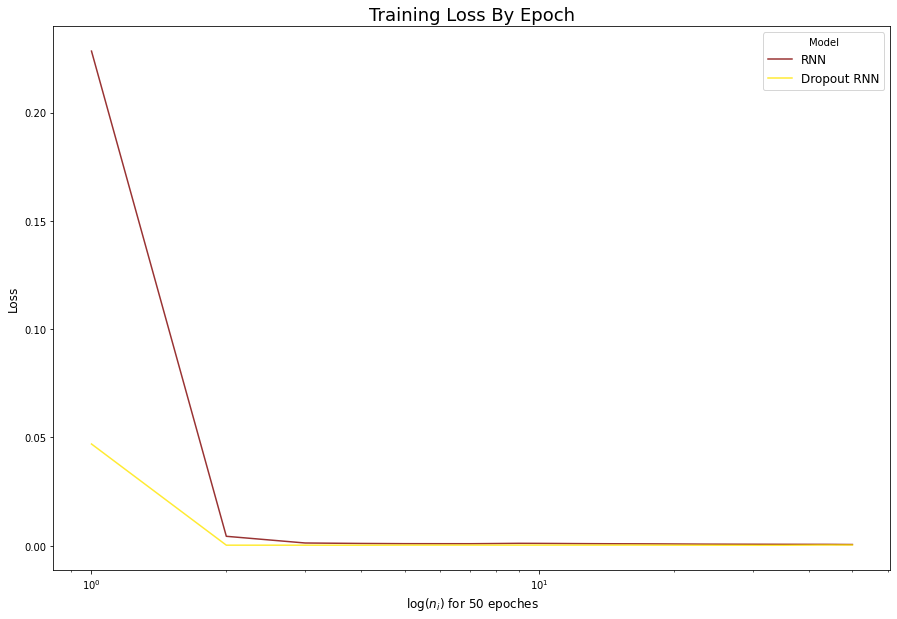

In [ ]:
# Plot training loss by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(1, 0, 4))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['loss'], color = colors[i], label = params[k]['label'], alpha = 0.8)
    i += 1
    
plt.xscale('log')
plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('$\log{(n_i)}$ for '  + str(n_epoches) + ' epoches', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Training Loss By Epoch', fontsize = 18)

plt.show()

Text(0.5, 1.0, 'Near-term Forecasting Residual ($\\hat{Y_i} - Y_i$)')

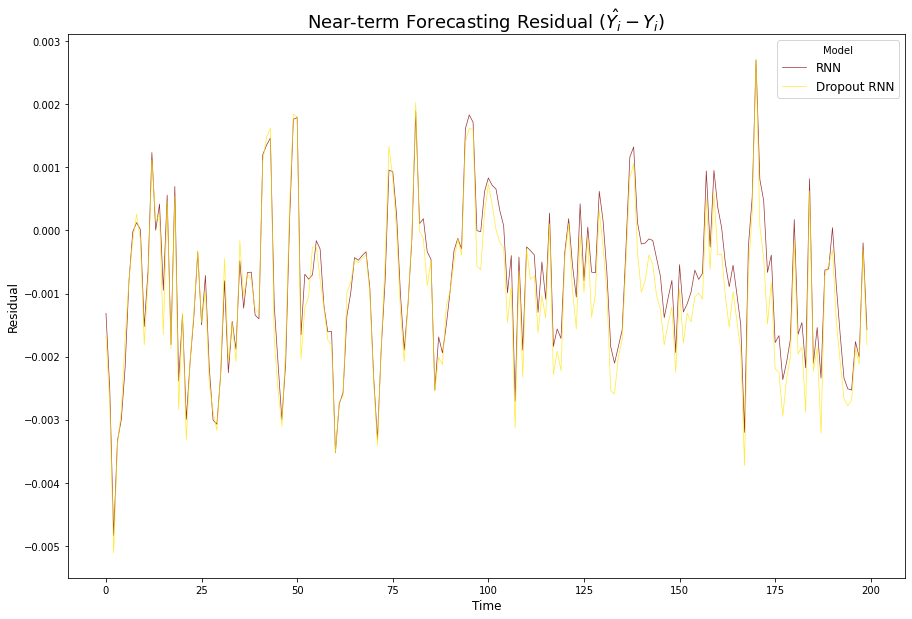

In [ ]:
# Plot near_term forecasting residuals for test set
upper_limit = 200
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit).reshape(upper_limit, 1)
colors = pl.cm.jet(np.linspace(1, 0, 4))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:upper_limit] - y_test_reg[:upper_limit].reshape(upper_limit, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.8, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Near-term Forecasting Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

Text(0.5, 1.0, 'Trimmed Test Residual ($\\hat{Y_i} - Y_i$)')

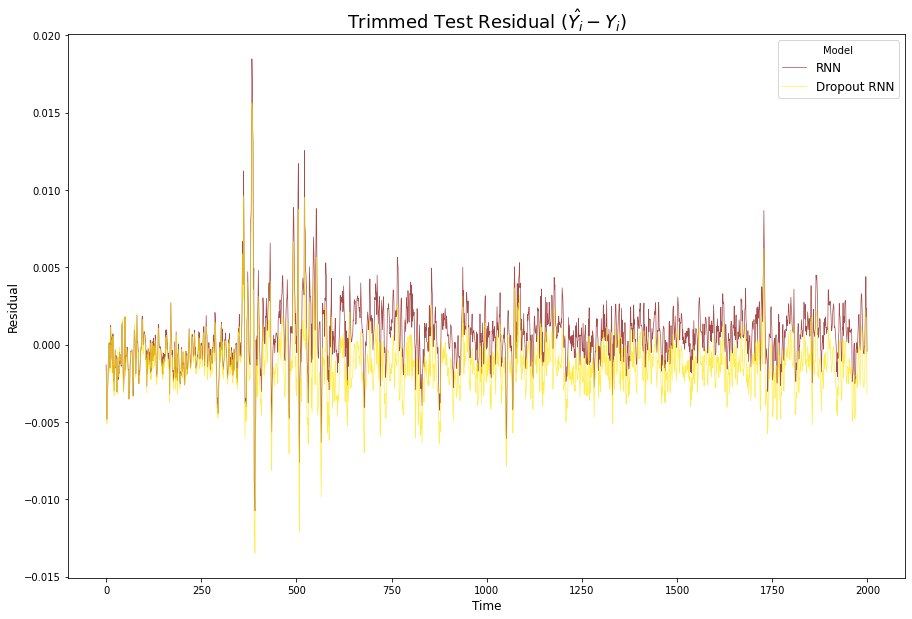

In [ ]:
# Plot trimmed residuals for test set
upper_limit = 2000
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit).reshape(upper_limit, 1)
colors = pl.cm.jet(np.linspace(1, 0, 4))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:upper_limit] - y_test_reg[:upper_limit].reshape(upper_limit, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Trimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

Text(0.5, 1.0, 'Untrimmed Test Residual ($\\hat{Y_i} - Y_i$)')

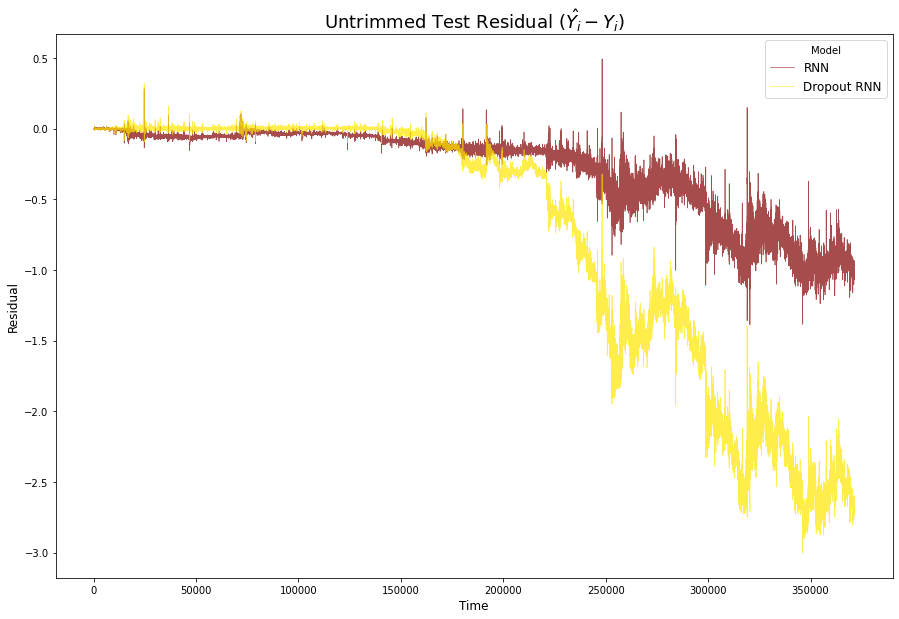

In [ ]:
# Plot untrimmed residuals for test set
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))
colors = pl.cm.jet(np.linspace(1, 0, 4))
i = 0

for k in params.keys():
    residual = params[k]['predict'] - y_test_reg
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Untrimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

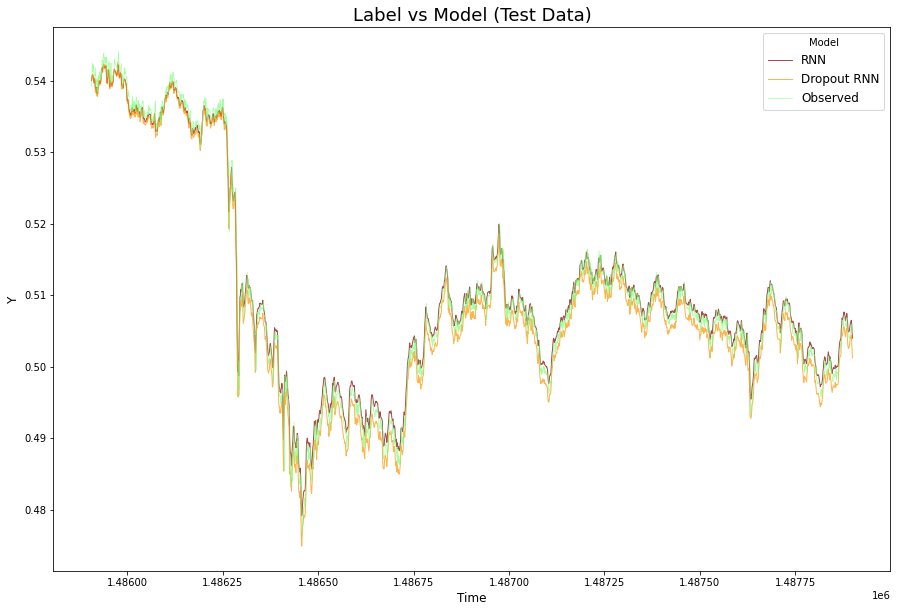

In [ ]:
# Plot prediction vs label performance
fig = plt.figure(figsize = (15, 10))
upper_limit = 2000
colors = pl.cm.jet(np.linspace(1, 0, 5))
i = 0

for k in params.keys():
    plt.plot(test.index[step_lag : upper_limit], params[k]['predict'][step_lag : upper_limit], linewidth = 1.0,
             color = colors[i], label = params[k]['label'], alpha = 0.7)
    i += 1
    
plt.plot(test.index[step_lag : upper_limit], test[features][step_lag : upper_limit], linewidth = 0.7,
         color = colors[i], label = 'Observed', alpha = 0.7)

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Label vs Model (Test Data)', fontsize = 18)

plt.show()

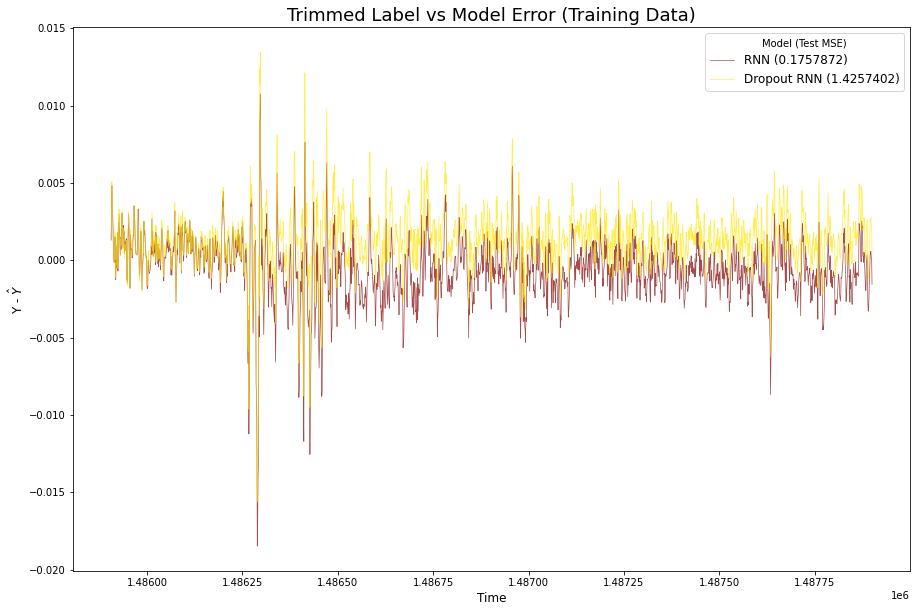

In [ ]:
# Plot prediction vs label error
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]
colors = pl.cm.jet(np.linspace(1, 0, 4))
i = 0

for k in params.keys():
    nn_y_plot = test[features][step_lag : upper_limit] - params[k]['predict'][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[i], label = params[k]['label'] + " (" + str( round( params[k]['MSE_test'], 7) ) + ")",
             alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model (Test MSE)', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('Trimmed Label vs Model Error (Training Data)', fontsize = 18)

plt.show()

In [ ]:
print('Model Errors:')

for k in params.keys():
    print('Model: ' + params[k]['label'])
    print('   Train MSE = ' + str(params[k]['MSE_train']))
    print('   Test MSE = ' + str(params[k]['MSE_test']))
    print()

Model Errors:
Model: RNN
   Train MSE = 0.0020183333301026355
   Test MSE = 0.1757872288316143

Model: Dropout RNN
   Train MSE = 0.001535569069841281
   Test MSE = 1.425740244495521



In [ ]:
print('Near-term Forecasting Error')
print()

for k in params.keys():
    print('Model: ' + params[k]['label'])
    temp = mean_squared_error(test[features][step_lag : 200], params[k]['predict'][step_lag : 200])
    print('   MSE = ' + str(temp))
    print()

Near-term Forecasting Error

Model: RNN
   MSE = 1.2372096415300602e-06

Model: Dropout RNN
   MSE = 1.9436148138206074e-06



In [ ]:
print('5-Fold GridCV Results')
print()

for k in params.keys():
    print('Model: ' + params[k]['label'])
    print(params[k]['cv_results'])

5-Fold GridCV Results

Model: RNN

Model: Dropout RNN
{'mean_fit_time': array([2.82612967, 2.36872091, 2.09261813, 2.29389782, 2.30390844,
       2.13456168, 2.21135674, 2.15789557, 2.24410915, 2.17532897,
       2.21632419, 2.24793005, 2.36946211, 2.16946893, 2.16765718,
       2.16640244, 2.16323218, 2.24212084, 2.14389038, 2.30264745,
       2.32791572, 2.32935314, 2.23830853, 2.18034821, 2.25701742,
       2.21382055, 2.24101233, 2.32733164, 2.23978558, 2.15073767,
       2.15169673, 2.39728856, 2.15512061, 2.21037822, 2.31937284,
       2.38414783, 2.43415418, 2.30032992, 2.15836406, 2.31055417,
       2.14761577, 2.23009686, 2.40604434, 2.13726997, 2.29606996,
       2.2202261 , 2.14857674, 2.31740594, 2.23434157, 2.13963089,
       2.22384906, 2.15183172, 2.42279029, 2.32446218, 2.20572314,
       2.20148759, 2.41742444, 2.20624824, 2.31338582, 2.18993297,
       2.24758668, 2.22647038, 2.31693959, 2.15110936, 2.31993876,
       2.14948177, 2.20846996, 2.21933327, 2.48037071, 2.